# Project D - Severstal Steel Defect Detection Kaggle Competition 
## Semantic Segmentation of steel defects
### Authors: Utkrisht Rajkumar, Subrato Chakravorty, Chi-Hsin Lo

This is the demo file used to qualitatively evaluate our models on validation and test images.

In [1]:
import os
import json
import gc
import cv2
import keras
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import sys
from data_gen import DataGenerator
import pickle

Using TensorFlow backend.


## Load Model

In [2]:
from utils import dice_coef, bce_dice, post_process
from model import relu6

In [5]:
model_path = './models/unet.h5'
cb={'bce_dice': bce_dice, 'dice_coef': dice_coef, 'relu6':relu6, 'tf':tf}
unet = load_model(model_path, custom_objects=cb)

model_path = './models/unet_res.h5'
unet_res = load_model(model_path, custom_objects=cb)

model_path = './models/unet_invres.h5'
unet_invres = load_model(model_path, custom_objects=cb)
model_path = './models/deeplabv3.h5'
deeplab = load_model(model_path, custom_objects=cb)

In [6]:
models = [unet, unet_res, unet_invres, deeplab]

## Qualitative results on validation images

Load 4 validation images and their ground truths and predict using all 4 models.

image idx:  11


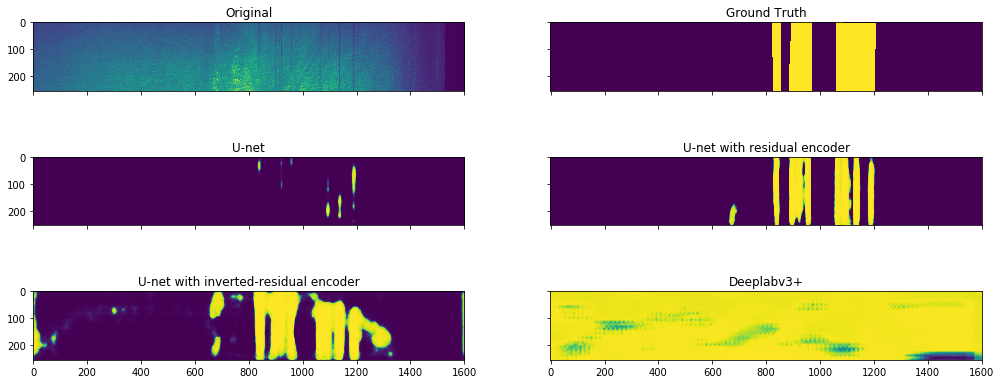

image idx:  12


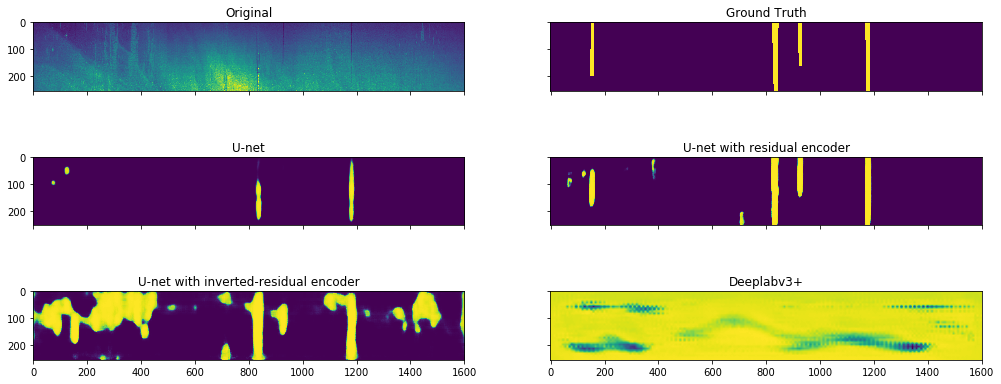

image idx:  13


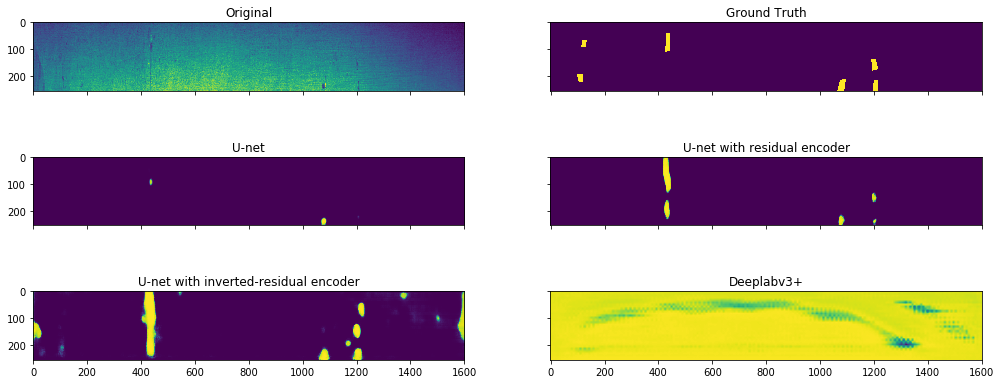

image idx:  14


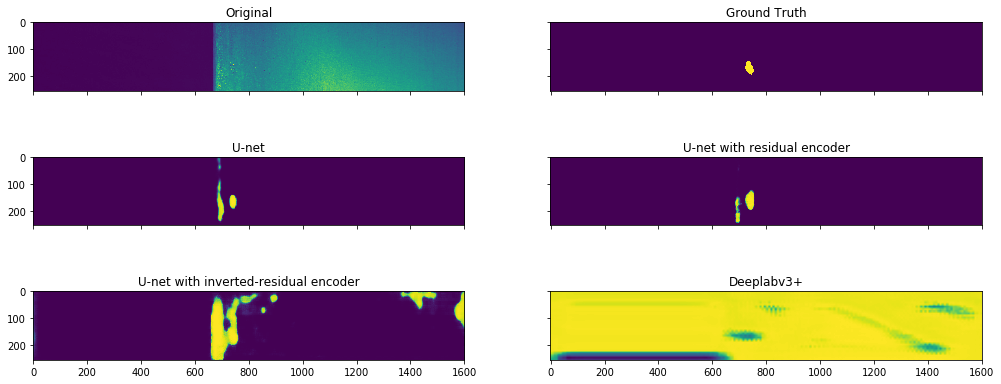

image idx:  15


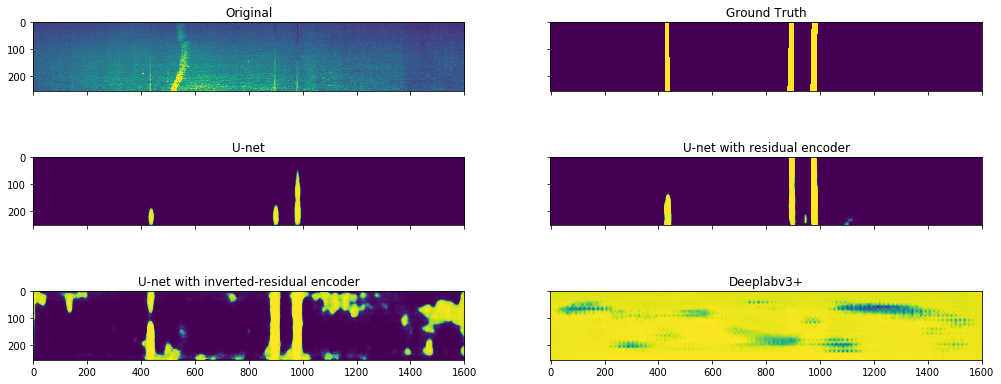

image idx:  16


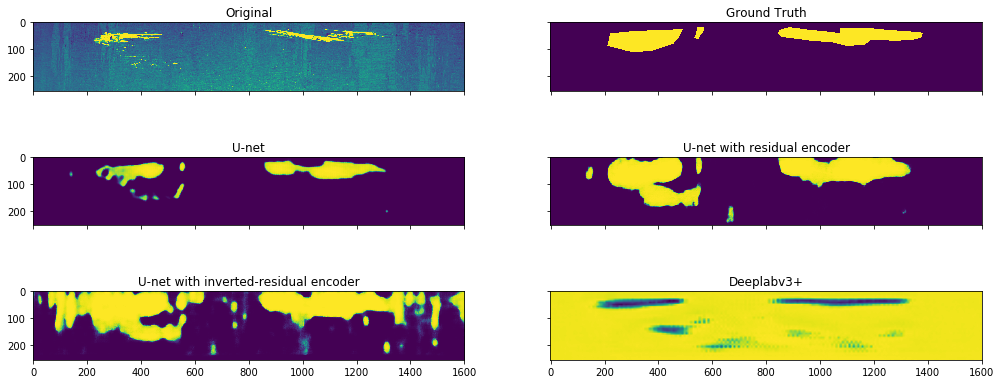

In [7]:
for idx in [11, 12, 13, 14, 15, 16]:
    print('image idx: ', idx)
    fig, ax = plt.subplots(3,2, figsize=(17,7), sharex=True, sharey=True)
    path = './ex_images/val_'+str(idx)+'.pickle'
    with open(path, 'rb') as f:
        test = pickle.load(f)
    ax[0,0].imshow(np.squeeze(test[0]))
    ax[0,1].imshow(np.sum(test[1], axis=-1))
    preds = [model.predict(np.expand_dims(test[0], axis=0)) for model in models]
    ax[1,0].imshow(np.squeeze(preds[0])[...,2]) 
    ax[1,1].imshow(np.squeeze(preds[1])[...,2]) 
    ax[2,0].imshow(np.squeeze(preds[2])[...,2])
    ax[2,1].imshow(np.squeeze(preds[3])[...,2])
    ax[0,0].set_title('Original'); ax[0,1].set_title('Ground Truth'); ax[1,0].set_title('U-net');ax[1,1].set_title('U-net with residual encoder')
    ax[2,0].set_title('U-net with inverted-residual encoder'); ax[2,1].set_title('Deeplabv3+')
    plt.show()

See report for analysis of our qualitative examples. 

## Contradiction between ground truth and prediction (Noisy labels)

image idx:  17


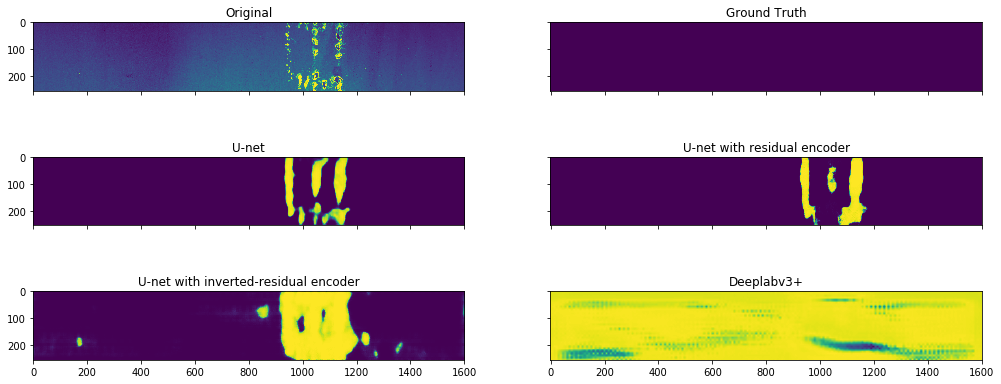

In [8]:
for idx in [17]:
    print('image idx: ', idx)
    fig, ax = plt.subplots(3,2, figsize=(17,7), sharex=True, sharey=True)
    path = './ex_images/val_'+str(idx)+'.pickle'
    with open(path, 'rb') as f:
        test = pickle.load(f)
    ax[0,0].imshow(np.squeeze(test[0]))
    ax[0,1].imshow(np.sum(test[1], axis=-1))
    preds = [model.predict(np.expand_dims(test[0], axis=0)) for model in models]
    ax[1,0].imshow(np.squeeze(preds[0])[...,2]) 
    ax[1,1].imshow(np.squeeze(preds[1])[...,2]) 
    ax[2,0].imshow(np.squeeze(preds[2])[...,2])
    ax[2,1].imshow(np.squeeze(preds[3])[...,2])
    ax[0,0].set_title('Original'); ax[0,1].set_title('Ground Truth'); ax[1,0].set_title('U-net');ax[1,1].set_title('U-net with residual encoder')
    ax[2,0].set_title('U-net with inverted-residual encoder'); ax[2,1].set_title('Deeplabv3+')
    plt.show()

## Qualitative results on test images

Load 4 test images and show prediction results

image idx:  30


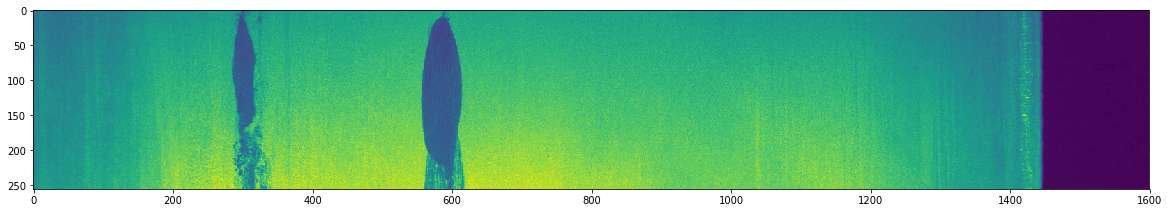

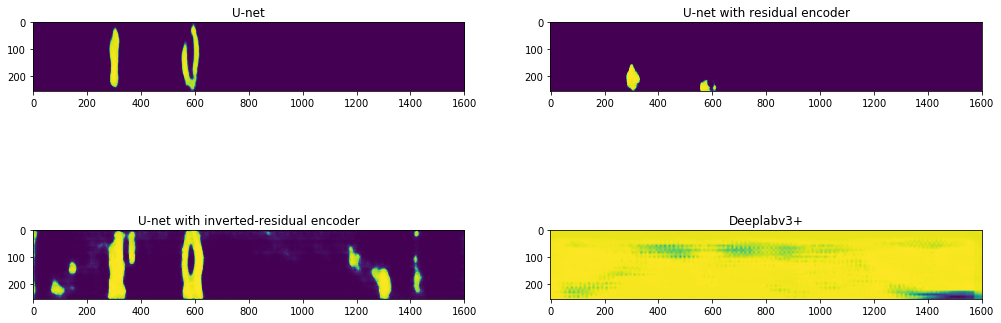

image idx:  20


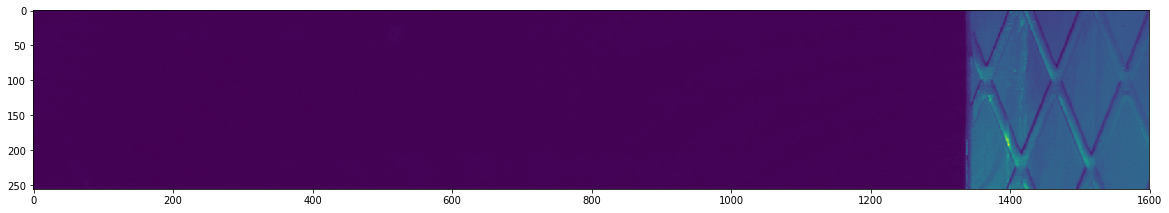

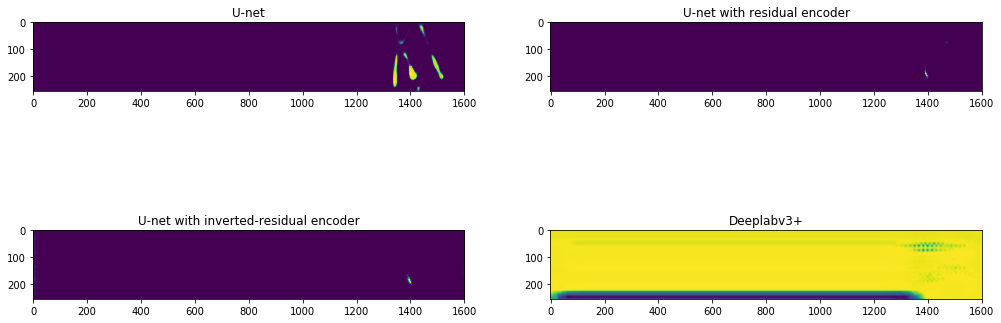

image idx:  40


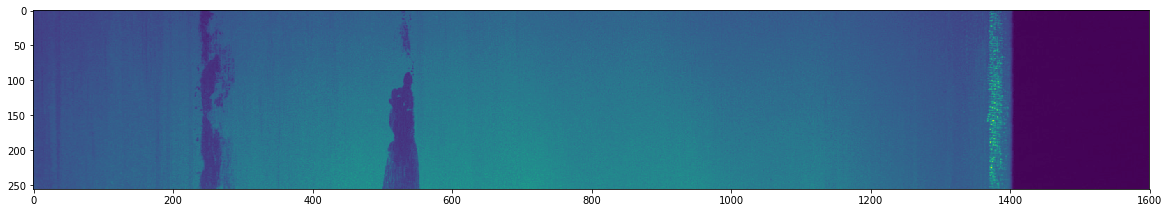

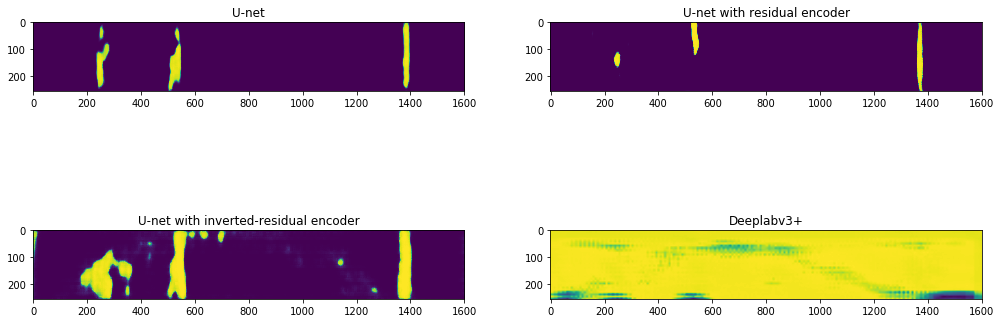

image idx:  70


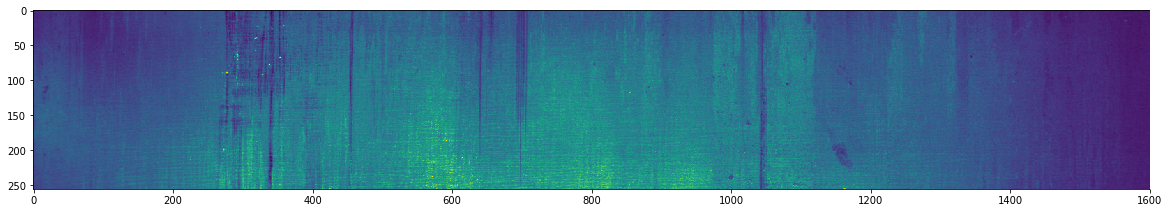

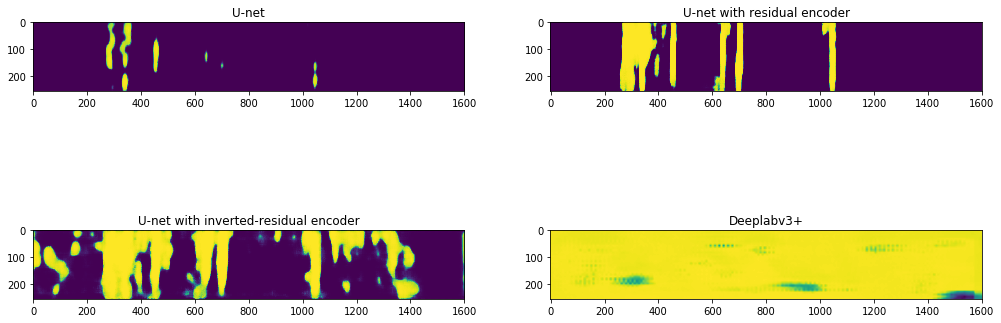

In [9]:
for idx in [30, 20, 40, 70]:
    print('image idx: ', idx)
    path = './ex_images/' + str(idx) + '.npy'
    test = np.load(path)
    plt.figure(figsize=(20,10)); plt.imshow(np.squeeze(test)); plt.show()
    fig, ax = plt.subplots(2,2, figsize=(17,7))
    preds = [model.predict(np.expand_dims(test, axis=0)) for model in models]
    ax[0,0].imshow(np.squeeze(preds[0])[...,2]) 
    ax[0,1].imshow(np.squeeze(preds[1])[...,2]) 
    ax[1,0].imshow(np.squeeze(preds[2])[...,2])
    ax[1,1].imshow(np.squeeze(preds[3])[...,2])
    ax[0,0].set_title('U-net');ax[0,1].set_title('U-net with residual encoder')
    ax[1,0].set_title('U-net with inverted-residual encoder'); ax[1,1].set_title('Deeplabv3+')
    plt.show()

In image id 30, the best model seems to be U-net, but in image id 20, the u-net seems to predict defects in an image where there seem to be none. In image id 40, the best prediction would probably be an ensemble between two u-net and u-net with residual encoder, and lastly in image 70, u-net with residual encoder seems to work the best. 

Although there exists no ground truth for us to verify this quantitatively, our experience with working with the data and seeing hundreds of such images their corresponding ground truths helps us make this claim.